- ID: ID duy nhất cho mỗi hồ sơ.
- KIDSDRIV: Số lượng trẻ em lái xe.
- BIRTH: Ngày sinh của người đóng bảo hiểm.
- AGE: Tuổi của người đóng bảo hiểm.
- HOMEKIDS: Số lượng trẻ em ở nhà.
- YOJ: Số năm kinh nghiệm lái xe của người đóng bảo hiểm.
- INCOME: Thu nhập của người đóng bảo hiểm.
- PARENT1: Biến đánh dấu liệu người đóng bảo hiểm có là phụ huynh không.
- HOME_VAL: Giá trị nhà của người đóng bảo hiểm.
- MSTATUS: Tình trạng hôn nhân.
- GENDER: Giới tính của người đóng bảo hiểm.
- EDUCATION: Trình độ học vấn của người đóng bảo hiểm.
- OCCUPATION: Nghề nghiệp của người đóng bảo hiểm.
- TRAVTIME: Thời gian di chuyển hàng ngày.
- CAR_USE: Mục đích sử dụng xe hơi.
- BLUEBOOK: Giá trị xe hơi.
- TIF: Thời gian sử dụng bảo hiểm.
- CAR_TYPE: Loại xe hơi.
- RED_CAR: Biến đánh dấu liệu có sử dụng xe màu đỏ không.
- OLDCLAIM: Số tiền đền bù từ các yêu cầu trước đây.
- CLM_FREQ: Số lần yêu cầu bồi thường trước đó.
- REVOKED: Biến đánh dấu liệu đã thu hồi bằng lái xe chưa.
- MVR_PTS: Điểm trên lệnh vi phạm giao thông.
- CLM_AMT: Số tiền đã yêu cầu bồi thường.
- CAR_AGE: Tuổi của xe hơi.
- CLAIM_FLAG: Biến đánh dấu liệu có yêu cầu bồi thường không.
- URBANICITY: Đô thị hoặc nông thôn.
Đô thị hoặc nông thôn.





In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)


e:\User\PC\ads_test


In [2]:
from config.config import *
from libs.common import *
init_notebook_mode(connected=True)
print(tf.__version__) # requires version >= 1.9.0

2.13.0


In [3]:
save_dir=f"{exps_dir}/exp3"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



In [4]:
data = pd.read_csv(f'{data_dir}/insurance_data.csv')
data

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,A,Major Loss,Police,0,1,GA,Savannah,4,AGENT00413,VNDR00556
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,A,Total Loss,Ambulance,1,0,AL,Montgomery,0,AGENT00769,VNDR00592
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,A,Total Loss,Police,0,1,CO,Grand Junction,19,AGENT00883,VNDR00031
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,A,Minor Loss,Ambulance,0,0,GA,Savannah,12,AGENT00278,VNDR00075
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,A,Major Loss,Police,0,1,TN,Nashville,18,AGENT00636,VNDR00472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2021-06-30 00:00:00,TXN00009996,A00006029,PLC00007245,2014-04-11,2021-06-25,2021-06-26,Motor,105.75,1000,...,A,Minor Loss,Ambulance,1,1,CT,Manchester,0,AGENT00779,NaN
9996,2021-06-30 00:00:00,TXN00009997,A00003555,PLC00002590,2015-08-25,2021-06-12,2021-06-17,Life,64.59,67000,...,A,Total Loss,Police,1,0,MA,Worcester,6,AGENT00254,VNDR00598
9997,2021-06-30 00:00:00,TXN00009998,A00004230,PLC00006613,2018-10-11,2021-06-18,2021-06-23,Health,183.50,8000,...,A,Major Loss,NaN,1,1,OK,Oklahoma City,12,AGENT00786,VNDR00104
9998,2021-06-30 00:00:00,TXN00009999,A00006694,PLC00001781,2016-01-29,2021-06-16,2021-06-21,Motor,113.46,2000,...,A,Total Loss,Ambulance,0,1,AR,Fayetteville,6,AGENT00927,VNDR00185


In [5]:
data.describe()

,PREMIUM_AMOUNT,CLAIM_AMOUNT,POSTAL_CODE,AGE,TENURE,NO_OF_FAMILY_MEMBERS,ROUTING_NUMBER,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_HOUR_OF_THE_DAY
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,88.508595,16563.830000,48288.830500,44.466100,62.949800,4.488400,7.052882e+07,0.699100,0.692800,11.604000
std,48.315874,22037.489735,32467.389801,11.516827,32.890604,1.712588,3.451879e+07,0.458672,0.461356,6.877101
min,6.000000,100.000000,1001.000000,25.000000,6.000000,2.000000,1.000074e+07,0.000000,0.000000,0.000000
25%,62.015000,2000.000000,21061.000000,34.000000,34.000000,3.000000,4.071761e+07,0.000000,0.000000,6.000000
50%,88.835000,7000.000000,37206.000000,45.000000,64.000000,4.000000,7.036614e+07,1.000000,1.000000,12.000000
75%,121.902500,21000.000000,80004.000000,54.000000,92.000000,6.000000,1.000638e+08,1.000000,1.000000,18.000000
max,200.000000,100000.000000,99669.000000,64.000000,119.000000,7.000000,1.299981e+08,1.000000,1.000000,23.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TXN_DATE_TIME             10000 non-null  object 
 1   TRANSACTION_ID            10000 non-null  object 
 2   CUSTOMER_ID               10000 non-null  object 
 3   POLICY_NUMBER             10000 non-null  object 
 4   POLICY_EFF_DT             10000 non-null  object 
 5   LOSS_DT                   10000 non-null  object 
 6   REPORT_DT                 10000 non-null  object 
 7   INSURANCE_TYPE            10000 non-null  object 
 8   PREMIUM_AMOUNT            10000 non-null  float64
 9   CLAIM_AMOUNT              10000 non-null  int64  
 10  CUSTOMER_NAME             10000 non-null  object 
 11  ADDRESS_LINE1             10000 non-null  object 
 12  ADDRESS_LINE2             1495 non-null   object 
 13  CITY                      9946 non-null   object 
 14  STATE  

In [7]:
data.head()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,A,Major Loss,Police,0,1,GA,Savannah,4,AGENT00413,VNDR00556
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,A,Total Loss,Ambulance,1,0,AL,Montgomery,0,AGENT00769,VNDR00592
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,A,Total Loss,Police,0,1,CO,Grand Junction,19,AGENT00883,VNDR00031
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,A,Minor Loss,Ambulance,0,0,GA,Savannah,12,AGENT00278,VNDR00075
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,A,Major Loss,Police,0,1,TN,Nashville,18,AGENT00636,VNDR00472


In [8]:
data.tail()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
9995,2021-06-30 00:00:00,TXN00009996,A00006029,PLC00007245,2014-04-11,2021-06-25,2021-06-26,Motor,105.75,1000,...,A,Minor Loss,Ambulance,1,1,CT,Manchester,0,AGENT00779,NaN
9996,2021-06-30 00:00:00,TXN00009997,A00003555,PLC00002590,2015-08-25,2021-06-12,2021-06-17,Life,64.59,67000,...,A,Total Loss,Police,1,0,MA,Worcester,6,AGENT00254,VNDR00598
9997,2021-06-30 00:00:00,TXN00009998,A00004230,PLC00006613,2018-10-11,2021-06-18,2021-06-23,Health,183.50,8000,...,A,Major Loss,NaN,1,1,OK,Oklahoma City,12,AGENT00786,VNDR00104
9998,2021-06-30 00:00:00,TXN00009999,A00006694,PLC00001781,2016-01-29,2021-06-16,2021-06-21,Motor,113.46,2000,...,A,Total Loss,Ambulance,0,1,AR,Fayetteville,6,AGENT00927,VNDR00185
9999,2021-06-30 00:00:00,TXN00010000,A00000390,PLC00005197,2014-09-17,2021-06-21,2021-06-24,Mobile,8.22,300,...,A,Total Loss,Ambulance,1,0,CT,Manchester,13,AGENT00118,VNDR00163


In [9]:
data.columns

Index(['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER',
       'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE',
       'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1',
       'ADDRESS_LINE2', 'CITY', 'STATE', 'POSTAL_CODE', 'SSN',
       'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS',
       'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE',
       'SOCIAL_CLASS', 'ROUTING_NUMBER', 'ACCT_NUMBER',
       'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY',
       'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE',
       'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY',
       'AGENT_ID', 'VENDOR_ID'],
      dtype='object')

In [10]:
data.isnull().sum()

TXN_DATE_TIME                  0
TRANSACTION_ID                 0
CUSTOMER_ID                    0
POLICY_NUMBER                  0
POLICY_EFF_DT                  0
LOSS_DT                        0
REPORT_DT                      0
INSURANCE_TYPE                 0
PREMIUM_AMOUNT                 0
CLAIM_AMOUNT                   0
CUSTOMER_NAME                  0
ADDRESS_LINE1                  0
ADDRESS_LINE2               8505
CITY                          54
STATE                          0
POSTAL_CODE                    0
SSN                            0
MARITAL_STATUS                 0
AGE                            0
TENURE                         0
EMPLOYMENT_STATUS              0
NO_OF_FAMILY_MEMBERS           0
RISK_SEGMENTATION              0
HOUSE_TYPE                     0
SOCIAL_CLASS                   0
ROUTING_NUMBER                 0
ACCT_NUMBER                    0
CUSTOMER_EDUCATION_LEVEL     529
CLAIM_STATUS                   0
INCIDENT_SEVERITY              0
AUTHORITY_

**Qua kiểm tra, ta dễ dàng nhận ra có 5 cột bị khuyết thiếu dữ liệu là cột "YOJ","INCOME","HOME_VAL","OCCUPATION","CAR_AGE".**

In [11]:
data.dtypes

TXN_DATE_TIME                object
TRANSACTION_ID               object
CUSTOMER_ID                  object
POLICY_NUMBER                object
POLICY_EFF_DT                object
LOSS_DT                      object
REPORT_DT                    object
INSURANCE_TYPE               object
PREMIUM_AMOUNT              float64
CLAIM_AMOUNT                  int64
CUSTOMER_NAME                object
ADDRESS_LINE1                object
ADDRESS_LINE2                object
CITY                         object
STATE                        object
POSTAL_CODE                   int64
SSN                          object
MARITAL_STATUS               object
AGE                           int64
TENURE                        int64
EMPLOYMENT_STATUS            object
NO_OF_FAMILY_MEMBERS          int64
RISK_SEGMENTATION            object
HOUSE_TYPE                   object
SOCIAL_CLASS                 object
ROUTING_NUMBER                int64
ACCT_NUMBER                  object
CUSTOMER_EDUCATION_LEVEL    

In [12]:
# data[['TXN_DATE_TIME','POLICY_EFF_DT','LOSS_DT','REPORT_DT']] = pd.to_datetime(data[['TXN_DATE_TIME','POLICY_EFF_DT','LOSS_DT','REPORT_DT']], format='%d%b%y')
# # data.ID = data.ID.astype('category')
# data


In [13]:
data.duplicated().sum()

0

**Nhóm phát hiện có một dòng trùng dữ liệu.**

In [14]:
data_duplicated = data[data.duplicated()]
data_duplicated

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID


In [15]:
# data.drop_duplicates(inplace=True)

In [16]:
numeric_columns = list(data.select_dtypes(['number']).columns)
object_columns = list(data.select_dtypes(['object']).columns)


In [17]:
change_tocategory = [i for i in numeric_columns if len(data[i].unique())<=10]
data[change_tocategory] = data[change_tocategory].astype('category')



In [18]:
object_columns = list(data.select_dtypes(['object']).columns)
len(object_columns)
numeric_columns = list(data.select_dtypes(['number']).columns)
len(numeric_columns)
print(f"Biến phân loại : {len(object_columns)}, Biến liên tục : {len(numeric_columns)}")

Biến phân loại : 28, Biến liên tục : 7


In [19]:
data[object_columns] = data[object_columns].astype('category')
object_columns = list(data.select_dtypes(['category']).columns)


In [20]:
data[object_columns].describe()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,CUSTOMER_NAME,ADDRESS_LINE1,...,CUSTOMER_EDUCATION_LEVEL,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,AGENT_ID,VENDOR_ID
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,9471,10000,10000,8055,10000,10000,10000,9954,10000,6755
unique,395,10000,10000,10000,3306,414,409,6,9880,3092,...,6,2,3,3,2,2,16,406,1200,407
top,2021-01-06 00:00:00,TXN00000001,A00000001,PLC00000001,2011-11-23,2021-04-02,2021-05-08,Mobile,Michael Johnson,2317 Fernwood Drive,...,Bachelor,A,Total Loss,Ambulance,1,1,CA,Manchester,AGENT00992,VNDR00535
freq,41,1,1,1,10,37,42,1692,6,12,...,3991,9497,3390,4082,6991,6928,1048,606,19,28


In [21]:
data[numeric_columns].describe()

,PREMIUM_AMOUNT,CLAIM_AMOUNT,POSTAL_CODE,AGE,TENURE,ROUTING_NUMBER,INCIDENT_HOUR_OF_THE_DAY
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,88.508595,16563.830000,48288.830500,44.466100,62.949800,7.052882e+07,11.604000
std,48.315874,22037.489735,32467.389801,11.516827,32.890604,3.451879e+07,6.877101
min,6.000000,100.000000,1001.000000,25.000000,6.000000,1.000074e+07,0.000000
25%,62.015000,2000.000000,21061.000000,34.000000,34.000000,4.071761e+07,6.000000
50%,88.835000,7000.000000,37206.000000,45.000000,64.000000,7.036614e+07,12.000000
75%,121.902500,21000.000000,80004.000000,54.000000,92.000000,1.000638e+08,18.000000
max,200.000000,100000.000000,99669.000000,64.000000,119.000000,1.299981e+08,23.000000


In [22]:
for column in object_columns : 
    print("\033[1m","*,Column : ", column,"\033[0m")
    print('\t',len(data[column].unique()),"unique values","\t & \t",
        data[column].notnull().sum(), "non-null values\t",
        round(100* data[column].notnull().sum()/len(data[column]),2),
        "% non-null")
    if len (data[column].unique())<=10 :
        print('\t',data[column].unique())

 *,Column :  TXN_DATE_TIME 
	 395 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  TRANSACTION_ID 
	 10000 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  CUSTOMER_ID 
	 10000 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  POLICY_NUMBER 
	 10000 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  POLICY_EFF_DT 
	 3306 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  LOSS_DT 
	 414 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  REPORT_DT 
	 409 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column :  INSURANCE_TYPE 
	 6 unique values 	 & 	 10000 non-null values	 100.0 % non-null
	 ['Health', 'Property', 'Travel', 'Life', 'Motor', 'Mobile']
Categories (6, object): ['Health', 'Life', 'Mobile', 'Motor', 'Property', 'Travel']
 *,Column :  CUSTOMER_NAME 
	 9880 unique values 	 & 	 10000 non-null values	 100.0 % non-null
 *,Column : 

KẾT LUẬN 
- Dựa vào thống kê các biến mang tính duy nhất ở cột phân loại, chúng ta thấy có 1 cột mang tính chất phân loại có tác dụng như mã số, mỗi dòng là một số cột khác nhau => Không quá quan trọng trong bộ dữ liệu nên ta có thể bỏ nó.
- Ngoài ra, ta có thể quan sát thấy các dòng có ký tự đặc biệt "$" tượng trưng cho ký hiệu tiền tệ USD ở các cột "Income","Home_Val","BlueBook","Oldclaim" không phù hợp với mô hình dự đoán, ta biến đổi những biến này sang biến liên tục.
- Cuối cùng, một số cột có dữ liệu bị bỏ trống.

In [23]:
for column in object_columns :
    if len(data[column].unique())<=10:
        print("-"*100)
        print("*,Column: ",column)
        print(data[column].value_counts())
        print('-'*100)

----------------------------------------------------------------------------------------------------
*,Column:  INSURANCE_TYPE
INSURANCE_TYPE
Mobile      1692
Property    1692
Health      1690
Life        1682
Travel      1670
Motor       1574
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
*,Column:  MARITAL_STATUS
MARITAL_STATUS
Y    7224
N    2776
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
*,Column:  EMPLOYMENT_STATUS
EMPLOYMENT_STATUS
Y    9171
N     829
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
---------------------------------------------

In [24]:
for column in object_columns:
    if len(data[column].unique())<=40:
        data[column].value_counts().iplot(kind='bar',title=column, 
                                        xTitle=column, 
                                        yTitle='Values')

In [25]:
numeric_columns

['PREMIUM_AMOUNT',
 'CLAIM_AMOUNT',
 'POSTAL_CODE',
 'AGE',
 'TENURE',
 'ROUTING_NUMBER',
 'INCIDENT_HOUR_OF_THE_DAY']

In [26]:
for column in numeric_columns : 
    print("*, Column: ",column)
    print(len(data[column].unique()), "unique values","\t & \t",
        data[column].notnull().sum(), "non-null values\t",
        round(100* data[column].notnull().sum()/len(data[column]),2),
        "% nono-null")
    if len(data[column].unique())<=10:
        print(data[column].unique())

*, Column:  PREMIUM_AMOUNT
6550 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  CLAIM_AMOUNT
107 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  POSTAL_CODE
669 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  AGE
40 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  TENURE
114 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  ROUTING_NUMBER
9995 unique values 	 & 	 10000 non-null values	 100.0 % nono-null
*, Column:  INCIDENT_HOUR_OF_THE_DAY
24 unique values 	 & 	 10000 non-null values	 100.0 % nono-null


KẾT LUẬN 
- Dù là kiểu dữ liệu số, nhưng một số cột thuộc kiểu dữ liệu rời rạc chứ không phải kiểu số liệu liên tục ( KIDSRIV, CLM_FREQ, CLAIM_FLAG,...) mang vai trò như một phân lớp. Chúng ta sẽ chuyển cột dữ liệu này sang kiểu dữ liệu mang tính phân loại để tăng hiệu suất dự án !
- Các biến rời rạc nhưng chiếm khá nhiều giá trị như tuổi nhóm sẽ xem xét chuyển sang cột phân loại như Young, Middle, Old để máy học tốt hơn.

In [27]:
change_tocategory = [i for i in numeric_columns if len(data[i].unique())<=30]
change_tocategory

['INCIDENT_HOUR_OF_THE_DAY']

In [28]:
data[change_tocategory] = data[change_tocategory].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   TXN_DATE_TIME             10000 non-null  category
 1   TRANSACTION_ID            10000 non-null  category
 2   CUSTOMER_ID               10000 non-null  category
 3   POLICY_NUMBER             10000 non-null  category
 4   POLICY_EFF_DT             10000 non-null  category
 5   LOSS_DT                   10000 non-null  category
 6   REPORT_DT                 10000 non-null  category
 7   INSURANCE_TYPE            10000 non-null  category
 8   PREMIUM_AMOUNT            10000 non-null  float64 
 9   CLAIM_AMOUNT              10000 non-null  int64   
 10  CUSTOMER_NAME             10000 non-null  category
 11  ADDRESS_LINE1             10000 non-null  category
 12  ADDRESS_LINE2             1495 non-null   category
 13  CITY                      9946 non-null   categ

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   TXN_DATE_TIME             10000 non-null  category
 1   TRANSACTION_ID            10000 non-null  category
 2   CUSTOMER_ID               10000 non-null  category
 3   POLICY_NUMBER             10000 non-null  category
 4   POLICY_EFF_DT             10000 non-null  category
 5   LOSS_DT                   10000 non-null  category
 6   REPORT_DT                 10000 non-null  category
 7   INSURANCE_TYPE            10000 non-null  category
 8   PREMIUM_AMOUNT            10000 non-null  float64 
 9   CLAIM_AMOUNT              10000 non-null  int64   
 10  CUSTOMER_NAME             10000 non-null  category
 11  ADDRESS_LINE1             10000 non-null  category
 12  ADDRESS_LINE2             1495 non-null   category
 13  CITY                      9946 non-null   categ

In [30]:
data

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,A,Major Loss,Police,0,1,GA,Savannah,4,AGENT00413,VNDR00556
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,A,Total Loss,Ambulance,1,0,AL,Montgomery,0,AGENT00769,VNDR00592
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,A,Total Loss,Police,0,1,CO,Grand Junction,19,AGENT00883,VNDR00031
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,A,Minor Loss,Ambulance,0,0,GA,Savannah,12,AGENT00278,VNDR00075
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,A,Major Loss,Police,0,1,TN,Nashville,18,AGENT00636,VNDR00472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2021-06-30 00:00:00,TXN00009996,A00006029,PLC00007245,2014-04-11,2021-06-25,2021-06-26,Motor,105.75,1000,...,A,Minor Loss,Ambulance,1,1,CT,Manchester,0,AGENT00779,NaN
9996,2021-06-30 00:00:00,TXN00009997,A00003555,PLC00002590,2015-08-25,2021-06-12,2021-06-17,Life,64.59,67000,...,A,Total Loss,Police,1,0,MA,Worcester,6,AGENT00254,VNDR00598
9997,2021-06-30 00:00:00,TXN00009998,A00004230,PLC00006613,2018-10-11,2021-06-18,2021-06-23,Health,183.50,8000,...,A,Major Loss,NaN,1,1,OK,Oklahoma City,12,AGENT00786,VNDR00104
9998,2021-06-30 00:00:00,TXN00009999,A00006694,PLC00001781,2016-01-29,2021-06-16,2021-06-21,Motor,113.46,2000,...,A,Total Loss,Ambulance,0,1,AR,Fayetteville,6,AGENT00927,VNDR00185


KẾT LUẬN
- Nhóm đã tiến hành chuyển đổi các cột có kí hiệu $ thành cột mới và đổi qua biến liên tục.

In [31]:
object_columns

['TXN_DATE_TIME',
 'TRANSACTION_ID',
 'CUSTOMER_ID',
 'POLICY_NUMBER',
 'POLICY_EFF_DT',
 'LOSS_DT',
 'REPORT_DT',
 'INSURANCE_TYPE',
 'CUSTOMER_NAME',
 'ADDRESS_LINE1',
 'ADDRESS_LINE2',
 'CITY',
 'STATE',
 'SSN',
 'MARITAL_STATUS',
 'EMPLOYMENT_STATUS',
 'NO_OF_FAMILY_MEMBERS',
 'RISK_SEGMENTATION',
 'HOUSE_TYPE',
 'SOCIAL_CLASS',
 'ACCT_NUMBER',
 'CUSTOMER_EDUCATION_LEVEL',
 'CLAIM_STATUS',
 'INCIDENT_SEVERITY',
 'AUTHORITY_CONTACTED',
 'ANY_INJURY',
 'POLICE_REPORT_AVAILABLE',
 'INCIDENT_STATE',
 'INCIDENT_CITY',
 'AGENT_ID',
 'VENDOR_ID']

In [32]:
numeric_columns=list(data.select_dtypes('number'))
numeric_columns

['PREMIUM_AMOUNT',
 'CLAIM_AMOUNT',
 'POSTAL_CODE',
 'AGE',
 'TENURE',
 'ROUTING_NUMBER']

In [33]:
nulldata_numeric =(data[numeric_columns]==0).sum()
nulldata_numeric

PREMIUM_AMOUNT    0
CLAIM_AMOUNT      0
POSTAL_CODE       0
AGE               0
TENURE            0
ROUTING_NUMBER    0
dtype: int64

In [34]:
for c in numeric_columns:
    data[c].iplot(kind='hist',title=c,xTitle=c)
    plt.show()

In [35]:
for c in numeric_columns:
    data[c].iplot(kind='box',title=c,xTitle=c,boxpoints='outliers')
    plt.show()

In [36]:
def check_outliers(name,outliers_list):
    we=data[name].values
    Q1=np.quantile(we,0.25)
    Q3=np.quantile(we,0.75)
    IQR=Q3-Q1
    print("Q1: ",Q1,"Q3: ",Q3,"IQR:",IQR)
    outliers=np.unique(we[[(n<Q1-1.5*IQR)|(n>Q3+1.5*IQR) for n in we]])
    indexes=[we.tolist().index(i) for i in outliers]
    if len(indexes)>0:
        outliers_list.append(name)
    print("Indexes of outliers: ", indexes)
    print("Number of outliers: ", len(indexes))
    print("Outlier values", we[indexes])
    print("-----")

In [37]:
outliers_list=[]
for col in numeric_columns:
    check_outliers(col,outliers_list)
np.savez(f'{save_dir}/outliers.npz', outliers = outliers_list)

print(outliers_list)

Q1:  62.015 Q3:  121.9025 IQR: 59.8875
Indexes of outliers:  []
Number of outliers:  0
Outlier values []
-----
Q1:  2000.0 Q3:  21000.0 IQR: 19000.0
Indexes of outliers:  [105, 13, 74, 474, 257, 239, 391, 1201, 370, 75, 76, 682, 672, 5, 1069, 1755, 44, 398, 19, 35, 296, 1312, 270, 261, 34, 1095, 1091, 692, 86, 80, 22, 2281, 1343, 473, 106, 1066, 124, 711, 1503, 295, 160, 666, 10, 2803, 2251, 94, 65, 120, 1391, 72, 116]
Number of outliers:  51
Outlier values [ 50000  51000  52000  53000  54000  55000  56000  57000  58000  59000
  60000  61000  62000  63000  64000  65000  66000  67000  68000  69000
  70000  71000  72000  73000  74000  75000  76000  77000  78000  79000
  80000  81000  82000  83000  84000  85000  86000  87000  88000  89000
  90000  91000  92000  93000  94000  95000  96000  97000  98000  99000
 100000]
-----
Q1:  21061.0 Q3:  80004.0 IQR: 58943.0
Indexes of outliers:  []
Number of outliers:  0
Outlier values []
-----
Q1:  34.0 Q3:  54.0 IQR: 20.0
Indexes of outliers:  []
Nu

KẾT LUẬN 
- Một số cột chứ rất nhiều giá trị ngoại lệ. Cần phải cân nhắc

In [38]:
corrle = data[numeric_columns].corr()
corrle

,PREMIUM_AMOUNT,CLAIM_AMOUNT,POSTAL_CODE,AGE,TENURE,ROUTING_NUMBER
PREMIUM_AMOUNT,1.000000,0.109210,-0.002926,-0.011634,0.006190,-0.013299
CLAIM_AMOUNT,0.109210,1.000000,0.014045,-0.001530,-0.001614,-0.003664
POSTAL_CODE,-0.002926,0.014045,1.000000,-0.015984,-0.002138,0.016885
AGE,-0.011634,-0.001530,-0.015984,1.000000,-0.004507,0.013480
TENURE,0.006190,-0.001614,-0.002138,-0.004507,1.000000,-0.009634
ROUTING_NUMBER,-0.013299,-0.003664,0.016885,0.013480,-0.009634,1.000000


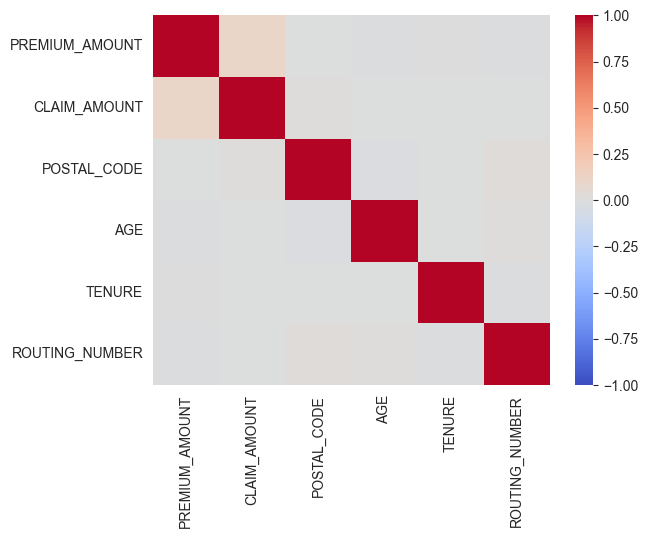

In [39]:
sns.heatmap(corrle, vmin=-1,vmax=1, annot=False,fmt=".2f",cmap='coolwarm')
plt.show()

KẾT LUẬN
- Dựa vào ma trận tương quan trên, ta nhận thấy những biến có tương quan mạnh : Income_converted & Home_val_converted (0.578943),Income_converted & car_age (0.417301), Home_val_converted & car_age (0.223198).
- Hầu như các biến không tương quan với nhau.

In [40]:
data

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,A,Major Loss,Police,0,1,GA,Savannah,4,AGENT00413,VNDR00556
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,A,Total Loss,Ambulance,1,0,AL,Montgomery,0,AGENT00769,VNDR00592
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,A,Total Loss,Police,0,1,CO,Grand Junction,19,AGENT00883,VNDR00031
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,A,Minor Loss,Ambulance,0,0,GA,Savannah,12,AGENT00278,VNDR00075
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,A,Major Loss,Police,0,1,TN,Nashville,18,AGENT00636,VNDR00472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2021-06-30 00:00:00,TXN00009996,A00006029,PLC00007245,2014-04-11,2021-06-25,2021-06-26,Motor,105.75,1000,...,A,Minor Loss,Ambulance,1,1,CT,Manchester,0,AGENT00779,NaN
9996,2021-06-30 00:00:00,TXN00009997,A00003555,PLC00002590,2015-08-25,2021-06-12,2021-06-17,Life,64.59,67000,...,A,Total Loss,Police,1,0,MA,Worcester,6,AGENT00254,VNDR00598
9997,2021-06-30 00:00:00,TXN00009998,A00004230,PLC00006613,2018-10-11,2021-06-18,2021-06-23,Health,183.50,8000,...,A,Major Loss,NaN,1,1,OK,Oklahoma City,12,AGENT00786,VNDR00104
9998,2021-06-30 00:00:00,TXN00009999,A00006694,PLC00001781,2016-01-29,2021-06-16,2021-06-21,Motor,113.46,2000,...,A,Total Loss,Ambulance,0,1,AR,Fayetteville,6,AGENT00927,VNDR00185


## **Chỉnh sửa dữ liệu**

- Sau những phân tích trên, chúng ta sẽ tiến hành chỉnh sử data theo kết luận trước đó

In [41]:
# bins = [16,30,60,81]
# labels=['Young','Middle','Old']
# data['AGE'] = pd.cut(data.AGE, bins=bins,labels=labels, right=False)
# data

Chuyển các giá trị trong cột AGE thành giá trị phân loại : 
- Young : từ 16-30 tuổi
- Middle : từ 30-60 tuổi
- Old : từ 60-81 tuổi

In [42]:
data.describe()

,PREMIUM_AMOUNT,CLAIM_AMOUNT,POSTAL_CODE,AGE,TENURE,ROUTING_NUMBER
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,88.508595,16563.830000,48288.830500,44.466100,62.949800,7.052882e+07
std,48.315874,22037.489735,32467.389801,11.516827,32.890604,3.451879e+07
min,6.000000,100.000000,1001.000000,25.000000,6.000000,1.000074e+07
25%,62.015000,2000.000000,21061.000000,34.000000,34.000000,4.071761e+07
50%,88.835000,7000.000000,37206.000000,45.000000,64.000000,7.036614e+07
75%,121.902500,21000.000000,80004.000000,54.000000,92.000000,1.000638e+08
max,200.000000,100000.000000,99669.000000,64.000000,119.000000,1.299981e+08


In [43]:
# data.CLAIM_FLAG.value_counts()

In [44]:
# sns.countplot(x='CLAIM_FLAG',data=data)
# plt.title("Biểu đồ yêu cầu bồi thường bảo hiểm")
# plt.show()

## KẾT LUẬN
-Tỉ lệ hồ sơ yêu cầu bồi thường bảo hiểm có sự chênh lệch quá lớn. Số hồ sơ không yêu cầu bổi thường gấp 3 lần số hồ sơ yêu cầu bồi thường. => (Imbalanced variable)

In [45]:
data.shape

(10000, 38)

In [46]:
data.AGE.value_counts()

AGE
53    278
28    276
44    276
49    271
47    268
33    267
55    267
52    266
62    265
50    262
32    262
56    259
29    259
37    258
54    256
60    255
48    254
58    252
25    252
26    251
35    248
46    248
42    247
31    246
40    245
27    244
57    243
38    243
30    241
61    239
64    239
51    238
43    237
39    233
41    233
45    231
63    229
34    227
36    227
59    208
Name: count, dtype: int64

In [47]:
sns.countplot(x="AGE",hue="CLAIM_FLAG",data=data)
plt.title("Biểu đồ thể hiện lứa tuổi của người yêu cầu bồi thường bảo hiểm")
plt.show()

ValueError: Could not interpret value `CLAIM_FLAG` for `hue`. An entry with this name does not appear in `data`.

Sự tương quan giữa age không được hiển thị rõ rệt ở các nhóm tuổi bởi vốn dĩ tỉ lệ số hồ sơ được cho là không gian lận quá lớn, gấp 3 lần số bộ hồ sơ gian lận. Tuy nhiên, ta có thể nhận thấy được nhóm tuổi yêu cầu đòi bòi thường bảo hiểm nhiều nhất là ở nhóm tuổi trung niên (Middle).


In [ ]:
data.OCCUPATION.value_counts()

z_Blue Collar    2288
Clerical         1590
Professional     1407
Manager          1257
Lawyer           1031
Student           899
Home Maker        843
Doctor            321
Name: OCCUPATION, dtype: int64

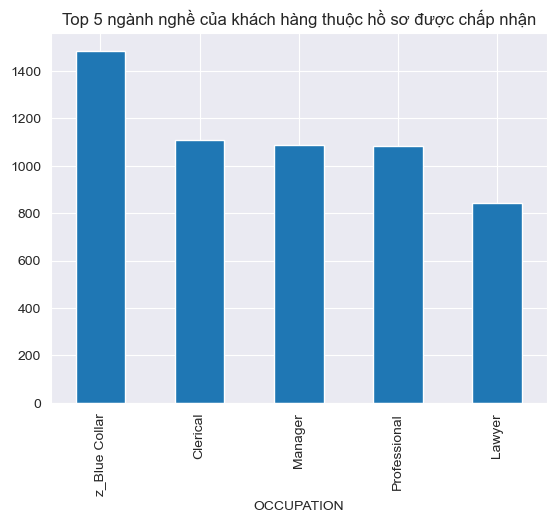

In [ ]:
OCCUPATION_Y = data[data.CLAIM_FLAG==0].groupby('OCCUPATION')['CLAIM_FLAG'].count().sort_values(ascending=False)
OCCUPATION_Y.head(5).plot.bar()
plt.title('Top 5 ngành nghề của khách hàng thuộc hồ sơ được chấp nhận')
plt.show()

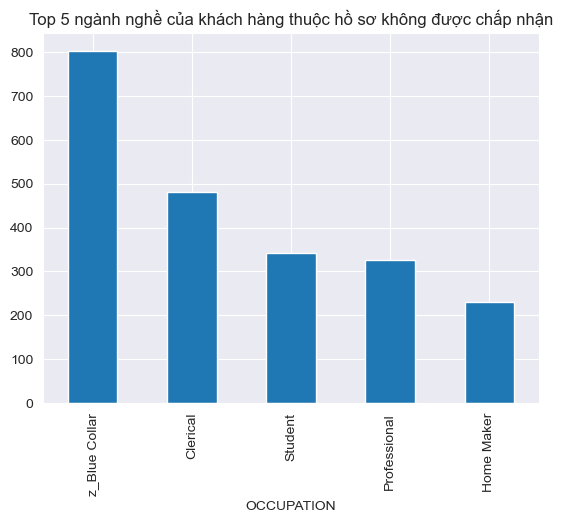

In [ ]:
OCCUPATION_N = data[data.CLAIM_FLAG==1].groupby('OCCUPATION')['CLAIM_FLAG'].count().sort_values(ascending=False)
OCCUPATION_N.head(5).plot.bar()
plt.title('Top 5 ngành nghề của khách hàng thuộc hồ sơ không được chấp nhận')
plt.show()

## KẾT LUẬN
- Có thể thấy rõ sự khác nhau về nghề nghiệp của khách hàng giữa bộ hồ sơ gian lận với được chấp nhận.
- Chúng ta có thể cân nhắc đây là một đặc trưng đưa vào mô hình dự đoán!

In [ ]:
available_request=data[data['CLAIM_FLAG']==1]

In [ ]:
data.GENDER.value_counts()

z_F    5545
M      4756
Name: GENDER, dtype: int64

In [ ]:
sns.histplot(data=data,x="HOME_VAL",hue="GENDER");
plt.title("Biểu đồ thể hiện tương quan giới tính với số giá trị nhà người nộp bảo hiểm")
plt.show()

In [ ]:
g = sns.displot(data, x = 'HOME_VAL_converted', col= 'GENDER', kde = True) # chỉ vẽ kde: kind = 'kde'
plt.suptitle('Phân phối giá trị nhà theo giới tính', y = 1.03)
g.set_ylabels('Số hóa đơn')
plt.show()

NameError: name 'sns' is not defined

<Axes: xlabel='CLAIM_FLAG', ylabel='count'>

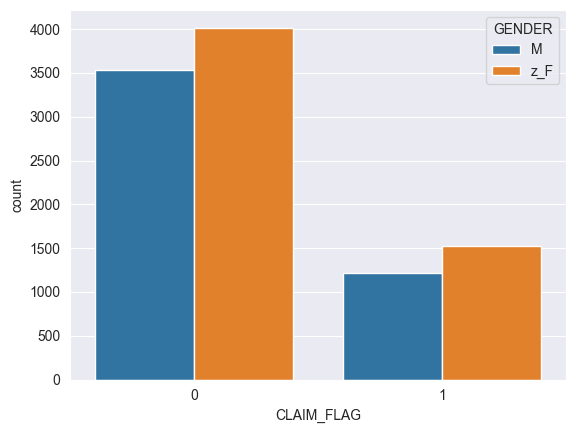

In [ ]:
sns.countplot(x='CLAIM_FLAG',hue='GENDER',data=data)

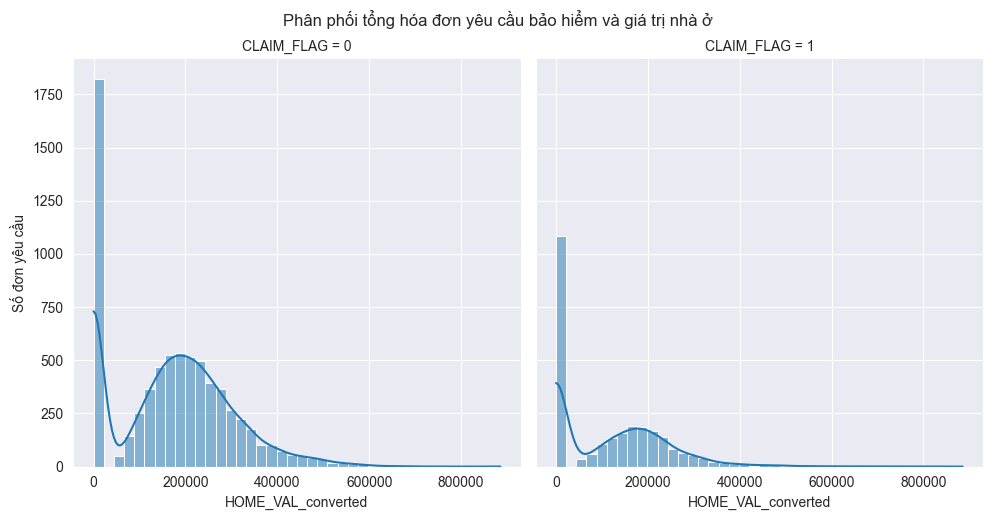

In [ ]:
g = sns.displot(data, x = 'HOME_VAL_converted', col= 'CLAIM_FLAG', kde = True) # chỉ vẽ kde: kind = 'kde'
plt.suptitle('Phân phối tổng hóa đơn yêu cầu bảo hiểm và giá trị nhà ở', y = 1.03)
g.set_ylabels('Số đơn yêu cầu')
plt.show()

In [48]:
data.to_excel(f'{save_dir}/data_EDA.xlsx', index=None)
object_columns = list(data.select_dtypes(['object']).columns)
data[object_columns]=data[object_columns].astype('category')
category_columns = list(data.select_dtypes(['category']).columns)
numeric_columns = list(data.select_dtypes(['number']).columns)

np.savez(f'{save_dir}/columns_dtype.npz', category_columns = category_columns, numeric_columns = numeric_columns)
data.to_csv(f'{save_dir}/data_EDA.csv',index=None)